<a href="https://colab.research.google.com/github/prksh830/Healthcare/blob/main/oos_gnn(1_0303).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
# Load dataset
data = pd.read_csv('wsn-ds.csv')

In [ ]:
# 🧾 Display total samples
print(f"Total samples in dataset: {df.shape[0]}")
print("\nSample data:\n", df.head())

Total samples in dataset: 374661

Sample data:
        id   Time   Is_CH   who CH   Dist_To_CH   ADV_S   ADV_R   JOIN_S  \
0  101000     50       1   101000      0.00000       1       0        0   
1  101001     50       0   101044     75.32345       0       4        1   
2  101002     50       0   101010     46.95453       0       4        1   
3  101003     50       0   101044     64.85231       0       4        1   
4  101004     50       0   101010      4.83341       0       4        1   

    JOIN_R   SCH_S   SCH_R  Rank   DATA_S   DATA_R   Data_Sent_To_BS  \
0       25       1       0     0        0     1200                48   
1        0       0       1     2       38        0                 0   
2        0       0       1    19       41        0                 0   
3        0       0       1    16       38        0                 0   
4        0       0       1    25       41        0                 0   

    dist_CH_To_BS   send_code   Consumed Energy Attack type  
0     

In [ ]:
# ✅ Check unique attack types
print("\nUnique Attack Types:\n", df['Attack type'].value_counts())


Unique Attack Types:
 Attack type
Normal       340066
Grayhole      14596
Blackhole     10049
TDMA           6638
Flooding       3312
Name: count, dtype: int64


<ipython-input-48-5ada88f30dc2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attack_counts.index, y=attack_counts.values, palette="viridis")


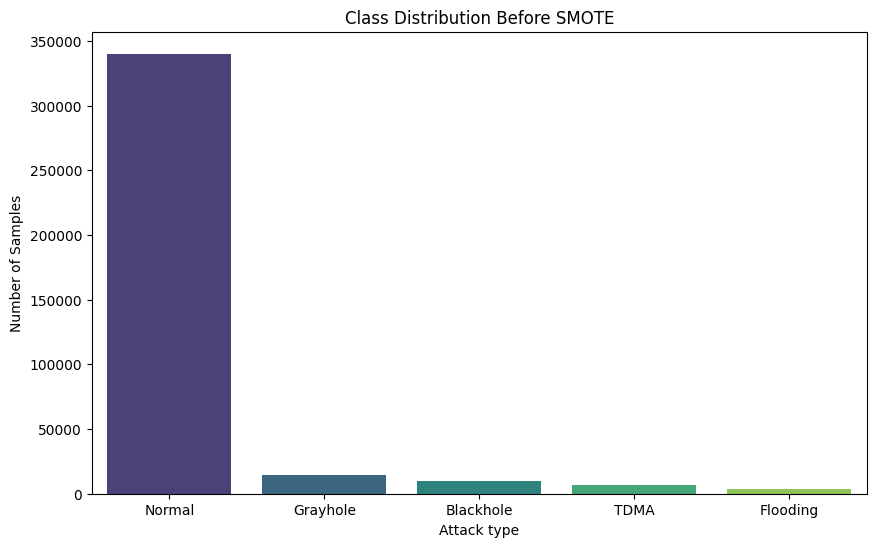

In [ ]:
# 🔢 Visualize class distribution before SMOTE
attack_counts = df['Attack type'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=attack_counts.index, y=attack_counts.values, palette="viridis")
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Attack type')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
# 🧹 Preprocess dataset
X = df.drop(['Attack type'], axis=1)
y = df['Attack type']

In [ ]:
# Prepare features and target
X = data.drop('Attack type', axis=1)
y = data['Attack type']

In [ ]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

In [ ]:
# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Split BEFORE SMOTE
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Confusion matrices before SMOTE using RandomForest
rf_before = RandomForestClassifier(n_estimators=100, random_state=42)
rf_before.fit(X_train_orig, y_train_orig)
y_train_pred_orig = rf_before.predict(X_train_orig)
y_test_pred_orig = rf_before.predict(X_test_orig)

In [ ]:
print("\nConfusion Matrix - Training (Before SMOTE):")
print(confusion_matrix(y_train_orig, y_train_pred_orig))


Confusion Matrix - Training (Before SMOTE):
[[  8006      0      0      0      0]
 [     0   2681      0      0      0]
 [     0      0  11611      0      0]
 [     0      0      0 272101      0]
 [     0      0      0      2   5327]]


In [ ]:
print("\nConfusion Matrix - Testing (Before SMOTE):")
print(confusion_matrix(y_test_orig, y_test_pred_orig))


Confusion Matrix - Testing (Before SMOTE):
[[ 2032     0    11     0     0]
 [    0   618     0    13     0]
 [   17     0  2946    22     0]
 [    0    38    31 67892     4]
 [    3     0     0    84  1222]]


In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# Show class distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(Counter(y_resampled))


Class distribution after SMOTE:
Counter({'Normal': 340066, 'Flooding': 340066, 'TDMA': 340066, 'Grayhole': 340066, 'Blackhole': 340066})


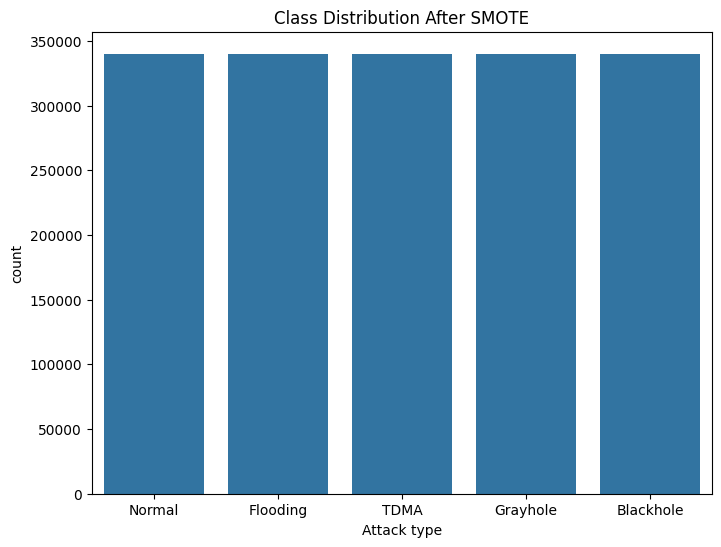

In [ ]:
# Bar chart after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)
plt.title('Class Distribution After SMOTE')
plt.show()

In [ ]:
# Split AFTER SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Define individual classifiers for the OOS-GNN ensemble
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf3 = KNeighborsClassifier(n_neighbors=5)

In [ ]:
# List individual classifiers
print("\nIndividual classifiers used in the OOS-GNN ensemble:")
print("- Random Forest")
print("- Gradient Boosting")
print("- K-Nearest Neighbors")


Individual classifiers used in the OOS-GNN ensemble:
- Random Forest
- Gradient Boosting
- K-Nearest Neighbors


In [ ]:
# Create the ensemble (OOS-GNN Mock)
oos_gnn = VotingClassifier(estimators=[
    ('rf', clf1),
    ('gb', clf2),
    ('knn', clf3)
], voting='soft', n_jobs=-1)

In [ ]:
# Fit the ensemble
start_time = time.time()
oos_gnn.fit(X_train, y_train)
train_time = time.time() - start_time

NameError: name 'oos_gnn' is not defined

Total samples in dataset: 374661

Sample data:
        id   Time   Is_CH   who CH   Dist_To_CH   ADV_S   ADV_R   JOIN_S  \
0  101000     50       1   101000      0.00000       1       0        0   
1  101001     50       0   101044     75.32345       0       4        1   
2  101002     50       0   101010     46.95453       0       4        1   
3  101003     50       0   101044     64.85231       0       4        1   
4  101004     50       0   101010      4.83341       0       4        1   

    JOIN_R   SCH_S   SCH_R  Rank   DATA_S   DATA_R   Data_Sent_To_BS  \
0       25       1       0     0        0     1200                48   
1        0       0       1     2       38        0                 0   
2        0       0       1    19       41        0                 0   
3        0       0       1    16       38        0                 0   
4        0       0       1    25       41        0                 0   

    dist_CH_To_BS   send_code   Consumed Energy Attack type  
0     

<ipython-input-1-811b44bf7e2b>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attack_counts.index, y=attack_counts.values, palette="viridis")


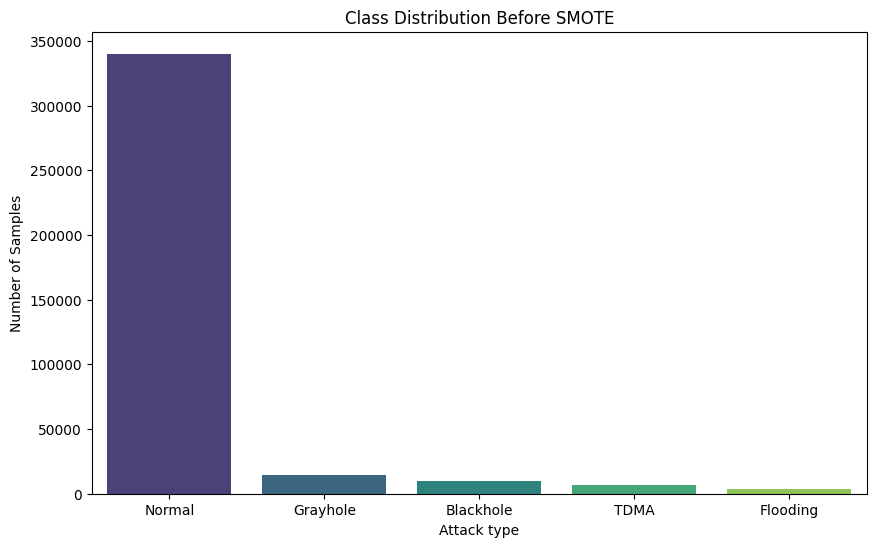


Confusion Matrix - Training (Before SMOTE):
[[  8006      0      0      0      0]
 [     0   2681      0      0      0]
 [     0      0  11611      0      0]
 [     0      0      0 272101      0]
 [     0      0      0      2   5327]]

Confusion Matrix - Testing (Before SMOTE):
[[ 2032     0    11     0     0]
 [    0   618     0    13     0]
 [   17     0  2946    22     0]
 [    0    38    31 67892     4]
 [    3     0     0    84  1222]]

Class distribution after SMOTE:
Counter({'Normal': 340066, 'Flooding': 340066, 'TDMA': 340066, 'Grayhole': 340066, 'Blackhole': 340066})


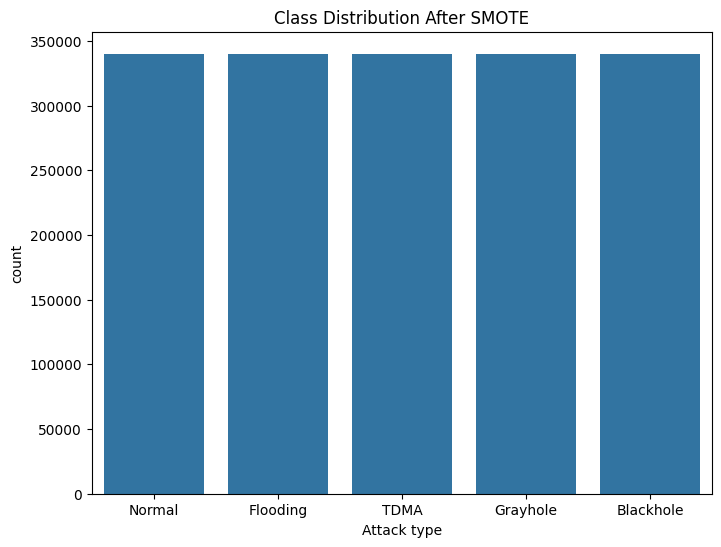


Individual classifiers used in the OOS-GNN ensemble:
- Random Forest
- Gradient Boosting
- K-Nearest Neighbors


In [1]:
from IPython import get_ipython
from IPython.display import display
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
# %%
# Load dataset
data = pd.read_csv('wsn-ds.csv')
# %%
# 🧾 Display total samples
print(f"Total samples in dataset: {data.shape[0]}") # Assuming 'df' should be 'data'
print("\nSample data:\n", data.head())            # Assuming 'df' should be 'data'
# %%
# ✅ Check unique attack types
print("\nUnique Attack Types:\n", data['Attack type'].value_counts()) # Assuming 'df' should be 'data'
# %%
# 🔢 Visualize class distribution before SMOTE
attack_counts = data['Attack type'].value_counts() # Assuming 'df' should be 'data'
plt.figure(figsize=(10,6))
sns.barplot(x=attack_counts.index, y=attack_counts.values, palette="viridis")
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Attack type')
plt.ylabel('Number of Samples')
plt.show()
# %%
# 🧹 Preprocess dataset
X = data.drop(['Attack type'], axis=1) # Assuming 'df' should be 'data'
y = data['Attack type']              # Assuming 'df' should be 'data'
# %%
# Prepare features and target
X = data.drop('Attack type', axis=1)
y = data['Attack type']
# %%
# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
# %%
# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
# %%
# Split BEFORE SMOTE
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42)
# %%
# Confusion matrices before SMOTE using RandomForest
rf_before = RandomForestClassifier(n_estimators=100, random_state=42)
rf_before.fit(X_train_orig, y_train_orig)
y_train_pred_orig = rf_before.predict(X_train_orig)
y_test_pred_orig = rf_before.predict(X_test_orig)
# %%
print("\nConfusion Matrix - Training (Before SMOTE):")
print(confusion_matrix(y_train_orig, y_train_pred_orig))
# %%
print("\nConfusion Matrix - Testing (Before SMOTE):")
print(confusion_matrix(y_test_orig, y_test_pred_orig))
# %%
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
# %%
# Show class distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(Counter(y_resampled))
# %%
# Bar chart after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)
plt.title('Class Distribution After SMOTE')
plt.show()
# %%
# Split AFTER SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
# %%
# Define individual classifiers for the OOS-GNN ensemble
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf3 = KNeighborsClassifier(n_neighbors=5)
# %%
# List individual classifiers
print("\nIndividual classifiers used in the OOS-GNN ensemble:")
print("- Random Forest")
print("- Gradient Boosting")
print("- K-Nearest Neighbors")
# %%
# Create the ensemble (OOS-GNN Mock)
oos_gnn = VotingClassifier(estimators=[
    ('rf', clf1),
    ('gb', clf2),
    ('knn', clf3)
], voting='soft', n_jobs=-1)
# %%
# Fit the ensemble
start_time = time.time()
oos_gnn.fit(X_train, y_train)
train_time = time.time() - start_time

In [2]:
# Training results
y_train_pred = oos_gnn.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_cm = confusion_matrix(y_train, y_train_pred)

In [3]:
# Testing results
start_time = time.time()
y_test_pred = oos_gnn.predict(X_test)
test_time = time.time() - start_time
test_accuracy = accuracy_score(y_test, y_test_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

In [4]:
print(f"\nOOS-GNN Training Accuracy: {train_accuracy:.4f}")
print(f"OOS-GNN Testing Accuracy: {test_accuracy:.4f}")
print(f"Training Time: {train_time:.2f}s, Testing Time: {test_time:.2f}s")

print("\nConfusion Matrix - Training (OOS-GNN):")
print(train_cm)

print("\nConfusion Matrix - Testing (OOS-GNN):")
print(test_cm)


OOS-GNN Training Accuracy: 0.9995
OOS-GNN Testing Accuracy: 0.9989
Training Time: 4023.84s, Testing Time: 3052.60s

Confusion Matrix - Training (OOS-GNN):
[[272058      0     13      0      0]
 [     0 271705      0      0      0]
 [    49      0 271861      0      0]
 [     5    240    196 271981     87]
 [     0      0      0     88 271981]]

Confusion Matrix - Testing (OOS-GNN):
[[67991     0     4     0     0]
 [    0 68360     0     1     0]
 [   36     0 68120     0     0]
 [    0    65    79 67358    55]
 [    1     0     0   145 67851]]


In [5]:
# Comparison with other methods
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(eval_metric='mlogloss')
}

accuracies = {}
times = {}
rocs = {}

In [ ]:
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    y_proba = model.predict_proba(X_test)
    roc = roc_auc_score(pd.get_dummies(y_test), y_proba, multi_class='ovr')

    accuracies[name] = acc
    times[name] = elapsed_time
    rocs[name] = roc
    print(f"{name} Accuracy: {acc:.4f}, Time: {elapsed_time:.2f}s, ROC AUC: {roc:.4f}")
    print(f"Confusion Matrix - {name}:\n{confusion_matrix(y_test, y_pred)}\n")

Random Forest Accuracy: 0.9991, Time: 480.97s, ROC AUC: 1.0000
Confusion Matrix - Random Forest:
[[67987     0     8     0     0]
 [    0 68359     0     2     0]
 [   29     0 68125     2     0]
 [    0    52    46 67426    33]
 [    2     0     0   124 67871]]

